##Hausaufgabe 2: Mehrklassenklassifikation

In [1]:

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from tensorflow.keras.utils import image_dataset_from_directory
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
from ipywidgets import interact, interactive, fixed, interact_manual, widgets

from google.colab import drive
import os



## Klassifikation mit einem ConvNet-Modell


## 1. Datenaufbereitung

In [2]:
drive.mount("/content/gdrive", force_remount = True)

dataset_dir = '/content/gdrive/My Drive/InVar100_76_90'
!ls "/content/gdrive/My Drive/InVar100_76_90"

Mounted at /content/gdrive
Schlauchschelle-14	   Schraube-DIN912-schwarz	 Schutzleiterklemme-2002-1207
Schlauchschelle-72	   Schraube-DIN912-schwarz-lang  Schutzleiterklemme-2002-rot
Schlauchschelle-gross	   Schraube-DIN921-M8x		 Senkkopfschraube-schwarz
Schraube-DIN912-Flachkopf  Schraubenfeder		 Sichtlagerkasten-rot
Schraube-DIN912-kurz	   Schutzbrille-Laser		 Stahlgitter-Zylinder


In [3]:
def create_dic(path_to_data_folder):
    data_dict = {}

    # Generate a list with the names of the subfolders (elements)
    element_names = next(os.walk(path_to_data_folder))[1]

    for element in element_names:
        element_path = os.path.join(path_to_data_folder, element)

        # Get the names of the images inside each element
        image_files = next(os.walk(element_path))[2]

        # Initialize the subfolder dictionary for the current element
        data_dict[element] = {}

        # Create a list of full paths for the images
        image_paths = [os.path.join(element_path, img) for img in image_files]

        # Add the images to the element's dictionary
        data_dict[element] = image_paths

    return data_dict, element_names


In [4]:
assert os.path.exists(dataset_dir), "Der pfad existiert nicht"

dic, elements_names = create_dic(dataset_dir)
print("Dictionary:", dic)
print(f"{len(elements_names)} Elements: {elements_names}")

Dictionary: {'Schlauchschelle-72': ['/content/gdrive/My Drive/InVar100_76_90/Schlauchschelle-72/Industrial_10.jpg', '/content/gdrive/My Drive/InVar100_76_90/Schlauchschelle-72/Industrial_1.jpg', '/content/gdrive/My Drive/InVar100_76_90/Schlauchschelle-72/Industrial_38.jpg', '/content/gdrive/My Drive/InVar100_76_90/Schlauchschelle-72/Industrial_40.jpg', '/content/gdrive/My Drive/InVar100_76_90/Schlauchschelle-72/IMG_20181220_154806.jpg', '/content/gdrive/My Drive/InVar100_76_90/Schlauchschelle-72/Industrial_33.jpg', '/content/gdrive/My Drive/InVar100_76_90/Schlauchschelle-72/Industrial_52.jpg', '/content/gdrive/My Drive/InVar100_76_90/Schlauchschelle-72/Industrial_8.jpg', '/content/gdrive/My Drive/InVar100_76_90/Schlauchschelle-72/Industrial_9.jpg', '/content/gdrive/My Drive/InVar100_76_90/Schlauchschelle-72/Industrial_4.jpg', '/content/gdrive/My Drive/InVar100_76_90/Schlauchschelle-72/Industrial_6.jpg', '/content/gdrive/My Drive/InVar100_76_90/Schlauchschelle-72/IMG_20181220_154800.jpg

In [6]:
# Images will be resized to 256x256 px
batch_size = 32
img_height = 256
img_width = 256

train_ds = tf.keras.utils.image_dataset_from_directory(
  dataset_dir,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

val_ds = tf.keras.utils.image_dataset_from_directory(
  dataset_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

val_batches = tf.data.experimental.cardinality(val_ds)
test_ds = val_ds.take(val_batches // 2)
val_ds = val_ds.skip(val_batches // 2)

class_names = train_ds.class_names
print(f"Class names: {class_names}")

# Check the first batch of images and labels
for images, labels in train_ds.take(1):
    print(f"Shape of image batch: {images.shape}")
    print(f"Shape of label batch: {labels.shape}")
    print(f"Labels: {labels.numpy()}")

for image_batch, labels_batch in train_ds:
  print(f"Batch size of {image_batch.shape[0]} where image has shape {image_batch.shape[1],image_batch.shape[2],image_batch.shape[3]}")
  print("Number of labels:", labels_batch.shape)
  break

Found 3120 files belonging to 15 classes.
Using 2496 files for training.
Found 3120 files belonging to 15 classes.
Using 624 files for validation.
Class names: ['Schlauchschelle-14', 'Schlauchschelle-72', 'Schlauchschelle-gross', 'Schraube-DIN912-Flachkopf', 'Schraube-DIN912-kurz', 'Schraube-DIN912-schwarz', 'Schraube-DIN912-schwarz-lang', 'Schraube-DIN921-M8x', 'Schraubenfeder', 'Schutzbrille-Laser', 'Schutzleiterklemme-2002-1207', 'Schutzleiterklemme-2002-rot', 'Senkkopfschraube-schwarz', 'Sichtlagerkasten-rot', 'Stahlgitter-Zylinder']
Shape of image batch: (32, 256, 256, 3)
Shape of label batch: (32,)
Labels: [ 6  8  4 14  7 12  2 14 13  6 10 14  2 12 12  7  4  5 12  2 11  0 13  8
 11  1 11  7  9  3 10 13]
Batch size of 32 where image has shape (256, 256, 3)
Number of labels: (32,)


In [7]:
## Visualize the data
# Display one random image for the chosen element
def display_random_image(element):
    if element in dic:
        i = np.random.randint(len(dic[element]))
        img_path = dic[element][i]
        plt.figure(figsize=(6,6))
        img = plt.imread(img_path)
        print("Image size", img.shape)
        plt.imshow(img)
        plt.show()
    else:
        print("Invalid element or category")

elements_dropdown = widgets.Dropdown(options = elements_names, description= "Elements")
interact(display_random_image, element = elements_dropdown)


interactive(children=(Dropdown(description='Elements', options=('Schlauchschelle-72', 'Schlauchschelle-14', 'S…

<function __main__.display_random_image(element)>

In [8]:
# Configure dataset for performance
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
test_ds = test_ds.cache().prefetch(buffer_size = AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [9]:
## data augmentation layer
data_augmentation = tf.keras.Sequential([
  tf.keras.layers.RandomFlip('horizontal'),
  tf.keras.layers.RandomRotation(0.2),
  tf.keras.layers.RandomZoom(0.1),
  tf.keras.layers.RandomContrast(0.1),
])

In [10]:
## Standardize the data - normalization leyer
# The RGB channel values are in the [0, 255] range.
# This is not ideal for a neural network; in general you should seek to make your input values small

normalization_layer = tf.keras.layers.Rescaling(1./255)

## 2. Aufbau des Modells

In [11]:
num_classes = len(elements_names)
input_shape = (img_height, img_width, 3)

# With data augmentation and dropout to reduce overfitting
base_model = tf.keras.Sequential([
  layers.Input(input_shape),
  data_augmentation,
  normalization_layer,
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dropout(0.2),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])


## 3. Kompilieren des Modells

In [12]:
base_learning_rate = 0.001
base_model.compile(
  optimizer=  tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
  loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
  metrics=['accuracy'])


In [13]:
base_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (None, 256, 256, 3)       0         
                                                                 
 rescaling (Rescaling)       (None, 256, 256, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 256, 256, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2  (None, 128, 128, 16)      0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 128, 128, 32)      4640      
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 64, 64, 32)        0         
 g2D)                                                 

## 4. Training des Modells

In [14]:
# You may notice the validation accuracy is low compared to the training accuracy,
# indicating your model is overfitting.

epochs = 25
history = base_model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)


Epoch 1/25
78/78 [==============================] - 134s 351ms/step - loss: 2.8329 - accuracy: 0.1298 - val_loss: 2.4465 - val_accuracy: 0.1941
Epoch 2/25
78/78 [==============================] - 1s 16ms/step - loss: 2.3602 - accuracy: 0.2284 - val_loss: 2.3536 - val_accuracy: 0.2434
Epoch 3/25
78/78 [==============================] - 1s 16ms/step - loss: 2.1371 - accuracy: 0.3085 - val_loss: 2.1862 - val_accuracy: 0.2993
Epoch 4/25
78/78 [==============================] - 1s 15ms/step - loss: 1.9807 - accuracy: 0.3361 - val_loss: 1.9008 - val_accuracy: 0.3651
Epoch 5/25
78/78 [==============================] - 1s 15ms/step - loss: 1.8734 - accuracy: 0.3774 - val_loss: 2.0838 - val_accuracy: 0.3388
Epoch 6/25
78/78 [==============================] - 1s 15ms/step - loss: 1.7278 - accuracy: 0.4143 - val_loss: 1.8894 - val_accuracy: 0.3717
Epoch 7/25
78/78 [==============================] - 1s 15ms/step - loss: 1.6081 - accuracy: 0.4700 - val_loss: 1.6818 - val_accuracy: 0.4638
Epoch 8/25

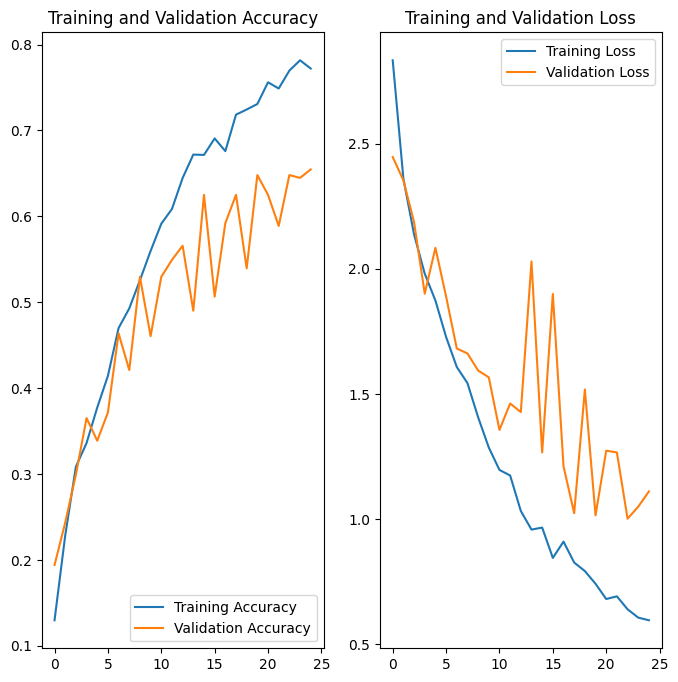

In [16]:
## Visualize training results. MIt data aug und dropout sollte val_acc = 0,6 und loss 1,4
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

## 5. Evaluation des trainierten Modells

In [17]:
# Evaluation on a third dataset - test database
loss, accuracy = base_model.evaluate(test_ds)
print(" loss: {:.2f}".format(loss))
print(" accuracy: {:.2f}".format(accuracy))

10/10 [==============================] - 4s 216ms/step - loss: 1.0529 - accuracy: 0.6687
 loss: 1.05
 accuracy: 0.67


## 6. Optimierung der Modellarchitektur und des Trainingsprozesses


In [18]:
!pip install keras_tuner

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.1/129.1 kB 3.9 MB/s eta 0:00:00


In [43]:
import keras_tuner
from tensorflow import keras
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

## Define model
class MyHyperModel(keras_tuner.HyperModel):
    def build(self, hp):
        model = keras.Sequential()

        # Data augmentation
        model.add(layers.Input(shape=input_shape))
        model.add(data_augmentation)
        model.add(normalization_layer)

        # Tune the number of filters in the Conv2D layers
        # Convolutional layers with batch normalization
        for i in range(hp.Int('num_conv_layers', 2, 4)):
            model.add(layers.Conv2D(
                filters=hp.Int(f'filters_{i}', min_value=16, max_value=128, step=16),
                kernel_size=3,
                padding='same',
                activation='relu'
            ))
            model.add(layers.MaxPooling2D())

        model.add(layers.Flatten())


        # Tune the number of dense layers
        for i in range(hp.Int('num_dense_layers', 1, 3)):
            model.add(layers.Dropout(hp.Float(f'dropout_{i}', 0.1, 0.5, step=0.1)))
            model.add(layers.Dense(hp.Int(f'units_{i}', 32, 512, step=32), activation='relu'))

        # Output layer
        model.add(layers.Dense(num_classes))

        # Tune the learning rate
        hp_learning_rate = hp.Float('learning_rate', min_value=1e-5, max_value=1e-2, sampling='LOG')

        model.compile(optimizer=keras.optimizers.Adam(learning_rate=hp_learning_rate),
                    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits = True),
                    metrics=['accuracy'])

        return model

    # Used to tune the training process during the hyperparameter search
    def fit(self, hp, model, *args, **kwargs):
        history= model.fit(
            *args,
            # Tune whether to shuffle the data in each epoch.
            shuffle=hp.Boolean("shuffle"),
            batch_size=hp.Int('batch_size', 16, 64, step=16),  # TRYOUT: Tune batch size 32,128
            **kwargs)
        # Clear session to free up memory
        keras.backend.clear_session()
        tf.compat.v1.reset_default_graph()
        return history


In [49]:
# Instantiate the tuner
import datetime

project_name = 'intro_to_kt_' + datetime.datetime.now().strftime("%Y%m%d_%H%M%S")
#project_name = "intro_to_kt_20240715_203258"
hypermodel = MyHyperModel()

# You may choose from RandomSearch, BayesianOptimization and Hyperband, which correspond to different tuning algorithms
'''tuner = keras_tuner.RandomSearch(
    hypermodel,
    objective='val_accuracy',
    max_trials=20,
    executions_per_trial=2,
    directory='my_dir',
    project_name=project_name)'''

tuner = keras_tuner.BayesianOptimization(
    MyHyperModel(),
    objective='val_accuracy',
    max_trials=20,
    executions_per_trial=1,
    directory='my_dir',
    project_name=project_name)

'''tuner = keras_tuner.Hyperband(
    MyHyperModel(),
    objective='val_accuracy',
    max_epochs=20,  #30
    directory='my_dir',
    project_name=project_name)'''

# Print a summary of the search space
tuner.search_space_summary()

# Run the tuner with early stopping callback and learning rate reduction callbacks
# ReduceLROnPlateau reduces learning rate when a metric has stopped improving.
early_stopping = EarlyStopping(monitor='val_loss',  # Metric to monitor
                               patience=5,  # Number of epochs with no improvement after which training will be stopped
                               restore_best_weights=True)   # Restore model weights from the epoch with the best value of the monitored metric
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=1e-5)

tuner.search(train_ds, epochs=50, validation_data=val_ds, callbacks = [early_stopping, reduce_lr])


# Get the optimal hyperparameters
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]


print(f"""
The hyperparameter search is complete. The optimal hyperparameters found are:
- Filters in first Conv2D layer: {best_hps.get('filters_1')}
- Filters in second Conv2D layer: {best_hps.get('filters_2')}
- Filters in third Conv2D layer: {best_hps.get('filters_3')}
- Number of dense layers: {best_hps.get('num_dense_layers')}
- Units in dense layers: {[best_hps.get(f'units_{i}') for i in range(best_hps.get('num_dense_layers'))]}
- Dropout rates: {[best_hps.get(f'dropout_{i}') for i in range(best_hps.get('num_dense_layers'))]}
- Learning rate: {best_hps.get('learning_rate')}
- Shuffle: {best_hps.get('shuffle')}
""")


Trial 20 Complete [00h 01m 22s]
val_accuracy: 0.35197368264198303

Best val_accuracy So Far: 0.7434210777282715
Total elapsed time: 00h 21m 59s

The hyperparameter search is complete. The optimal hyperparameters found are:
- Filters in first Conv2D layer: 64
- Filters in second Conv2D layer: 32
- Filters in third Conv2D layer: 48
- Number of dense layers: 1
- Units in dense layers: [256]
- Dropout rates: [0.30000000000000004]
- Learning rate: 0.0018821232789177442
- Shuffle: True



In [53]:
# Build the model with the optimal hyperparameters and train it on the data for a final evaluation

model = tuner.hypermodel.build(best_hps)
model.summary()
history = model.fit(train_ds,
                    epochs=100,
                    validation_data=val_ds,
                    batch_size=best_hps.get('batch_size'),  # TRYOUT: Use the best batch size found
                    shuffle=best_hps.get('shuffle'),
                    callbacks=[early_stopping, reduce_lr])
#history = model.fit(train_ds, epochs=15, validation_data=val_ds)

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (None, 256, 256, 3)       0         
                                                                 
 rescaling (Rescaling)       (None, 256, 256, 3)       0         
                                                                 
 conv2d_8 (Conv2D)           (None, 256, 256, 128)     3584      
                                                                 
 max_pooling2d_8 (MaxPoolin  (None, 128, 128, 128)     0         
 g2D)                                                            
                                                                 
 conv2d_9 (Conv2D)           (None, 128, 128, 64)      73792     
                                                                 
 max_pooling2d_9 (MaxPoolin  (None, 64, 64, 64)        0         
 g2D)                                                 

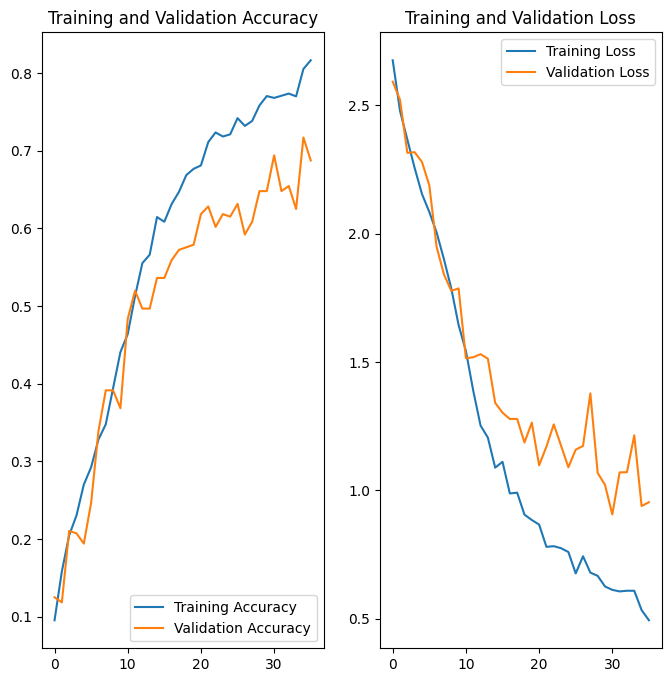

In [60]:
## Visualize training results.
from IPython.core.display import display, HTML
import matplotlib.pyplot as plt

# Increase notebook width
display(HTML("<style>.container { width:100% !important; }</style>"))

# Set default figure size
plt.rcParams['figure.figsize'] = [12, 8]  # or any size you need

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = 36
epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')
plt.rcParams['figure.figsize'] = [10, 6]  # Width, Height in inches

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [55]:
# Evaluate the model
loss, accuracy = model.evaluate(test_ds)
print(f"Test Loss: {loss}")
print(f"Test Accuracy: {accuracy}")

10/10 [==============================] - 0s 15ms/step - loss: 0.8429 - accuracy: 0.7031
Test Loss: 0.8428616523742676
Test Accuracy: 0.703125


## Speichern des Modells


In [56]:
model.save('./')

In [58]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))